## Constant fractional timing (CFT)

Here is a note to show how to simulate a CFT by using the data taking from osciliscope. The basic steps are:

1. Duplicate an opposite signal from the input siganl;
2. Scale the duplicated signal down by a constant fraction c;
3. Delay the original signal by Dt;
4. Supperposition the two signals together and then the cross over is the CFT.

The baseline is important to any timing and it will also affect the CFT as well.

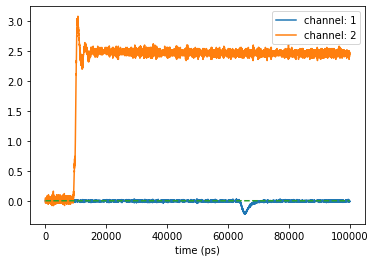

In [2]:
from mtdScope import scopeEmulator
import matplotlib.pyplot as plt
import numpy as np
import time
#from jupyterthemes import jtplot
#jtplot.style()
#import mtdProcess as mp
        
#load the sample data to test
se = scopeEmulator()
se.loadData('data/FBKsensor_LaserTesting/Batch2_6-3/HV110HP_DG.hdf5')
#se.loadData('./HV160_lowPower_100mV_11340R.hd5')
se.sliceEvent()
se.showEvent(2083,[1,2])

### Implementation

Here is a example to show on the intermediate steps for the CFT simulation: 

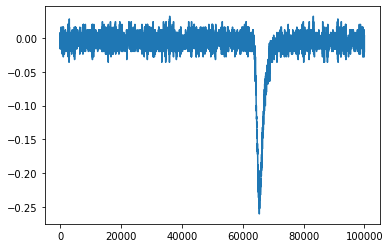

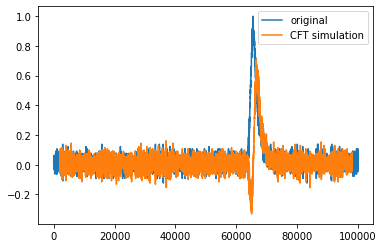

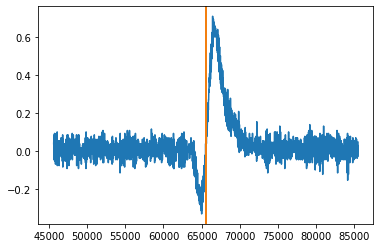

In [25]:
ievent = 9
points = se.getEventAdjusted(ievent)
plt.plot(points[0],points[1])
plt.show()
points = se.getEventYNormalized(ievent)
plt.plot(points[0],points[1],label='original')
y = se.simulateCFT(points[0],points[1])
ntrun = 100
plt.plot(points[0][ntrun:-ntrun],y(points[0][ntrun:-ntrun]),label='CFT simulation')
plt.legend(loc='best')
plt.show()
se.debug_cft(ievent, 1,'linear', 1000)

processing the 0th events...
processing the 1000th events...
processing the 2000th events...
time consumed: 9.115231275558472
-54581.793 970
-54873.684 951
jitter is: 38.185345


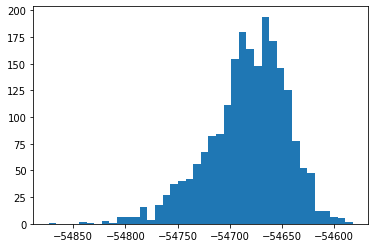

In [30]:
ts = se.runTimeWalk(0,se.nevent, 1000, 'linear')
dt = ts[1]-ts[0]
print(np.amax(dt),np.argmax(dt))
print(np.amin(dt),np.argmin(dt))
plt.hist(dt,bins =40)
print('jitter is:',dt.std())
